In [1]:
import boto3
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import s3fs
import random
import pickle
import io

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def loadLogs(name):
    s3_client = boto3.client('s3')
    array = io.BytesIO()
    s3_client.download_fileobj('sounddata', 'modeling/'+name+'.pkl', array)
    array.seek(0)
    return pickle.load(array)

In [3]:
e_loss_val = loadLogs('e_loss_val')
e_loss_train = loadLogs('e_loss_train')
e_acc_train = loadLogs('e_acc_train')
e_acc_val = loadLogs('e_acc_val')
e_class_train = loadLogs('e_class_train')
e_class_val = loadLogs('e_class_val')
e_range_train = loadLogs('e_range_train')
e_range_val = loadLogs('e_range_val')

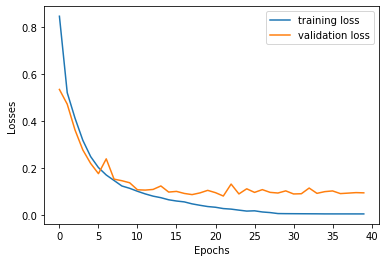

In [4]:
plt.plot(e_loss_train, label="training loss")
plt.plot(e_loss_val, label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

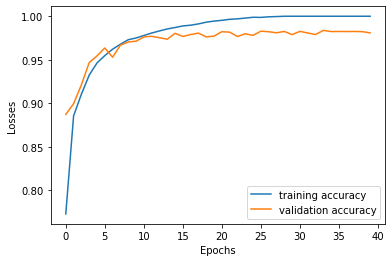

In [5]:
plt.plot(e_acc_train, label="training accuracy")
plt.plot(e_acc_val, label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

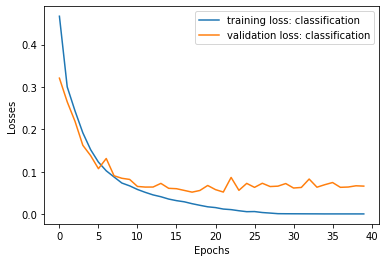

In [6]:
plt.plot(e_class_train, label="training loss: classification")
plt.plot(e_class_val, label="validation loss: classification")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

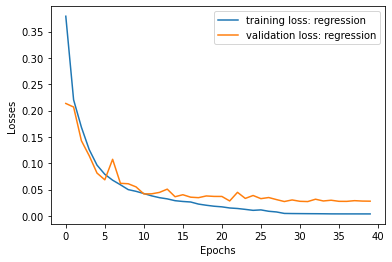

In [7]:
plt.plot(e_range_train, label="training loss: regression")
plt.plot(e_range_val, label="validation loss: regression")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

In [8]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 9, 2)
        self.conv2 = nn.Conv2d(10, 20, 7, 2)
        self.conv3 = nn.Conv2d(20, 35, 5, 2)
        
        self.fc1 = nn.Linear(35*42*43, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_class = nn.Linear(64, 2)
        self.fc_range = nn.Linear(64, 1)
        
    def forward(self, x):
        
        # convolutional layers
        x = F.relu(self.conv1(x))
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        #x = F.max_pool2d(x, 2)
        # flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y_class = self.fc_class(x)
        y_range = self.fc_range(x)
        
        return [y_class, y_range]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [13]:
model = simpleCNN()
model.load_state_dict(torch.load('simplecnn-real.pt'))
model = model.to(device)

In [14]:
s3 = s3fs.S3FileSystem()
f = h5py.File(s3.open("s3://sounddata/modeling/realistic/grid_data_val.h5", "rb"))


X = f["data"][:]
y = f["labels"][:]

In [15]:
import simpleCNN
from torch.utils.data import DataLoader
import tqdm
import sys

In [17]:
val_data = simpleCNN.SPECT(X, y)
BATCH_SIZE = 128
val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            #num_workers=4,
                            shuffle=True)

In [18]:
model.eval()
predsclass = []
predsrange=[]
class_labs=[]
range_labs=[]
with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader, desc='evaluating...', file=sys.stdout):
        dat, lab = batch
        prediction = model(dat.to(device))

        range_lab = lab[:, 0][:, None].to(device)

        class_lab = lab[:, 1].long().to(device)
        predicted_classes = prediction[0].argmax(dim=-1)
        
        class_lab = class_lab.detach().to('cpu').numpy()
            
        range_lab = range_lab.detach().to('cpu').numpy()

        class_labs.append(class_lab)
        range_labs.append(range_lab)
        predsclass.append(predicted_classes.detach().to('cpu').numpy())
        predsrange.append(prediction[1].detach().to('cpu').numpy())

evaluating...: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]


In [19]:
max_range = 35000
true_ranges =np.concatenate(range_labs, axis=0 )
range_preds = np.concatenate(predsrange, axis=0 )

true_class = np.concatenate(class_labs, axis=0 )
class_preds = np.concatenate(predsclass, axis=0 )

true_ranges = true_ranges[true_class == 1]*max_range
range_preds = range_preds[true_class == 1]*max_range

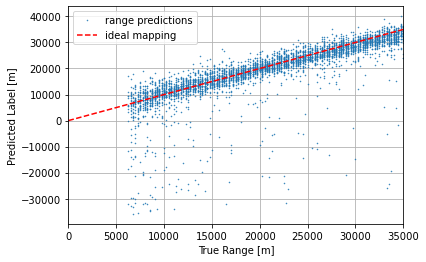

In [20]:
#plt.plot(np.concatenate(range_labs, axis=0 )*max_range, np.concatenate(predsrange, axis=0 )*max_range, 'o', markersize=0.5, label="range predictions")
plt.plot(true_ranges, range_preds, 'o', markersize=0.5, label="range predictions")
plt.plot([0, max_range], [0, max_range], 'r--', label="ideal mapping")
plt.grid()
plt.xlabel("True Range [m]")
plt.ylabel("Predicted Label [m]")
plt.legend()
plt.xlim([0,max_range])
#plt.ylim([0,max_range])
plt.show()

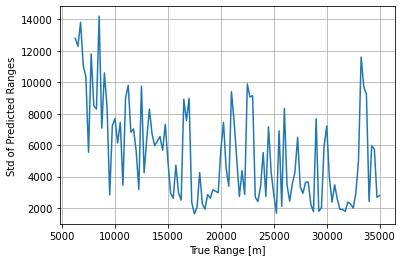

In [21]:
# Calculate std of predicted ranges for each given true range

unique_ranges = np.unique(true_ranges)
#unique_ranges.sort()
stds = [np.std(range_preds[true_ranges == r]) for r in unique_ranges]

# Plot results
plt.plot(unique_ranges, stds)
plt.grid()
plt.xlabel("True Range [m]")
plt.ylabel("Std of Predicted Ranges")
plt.show()

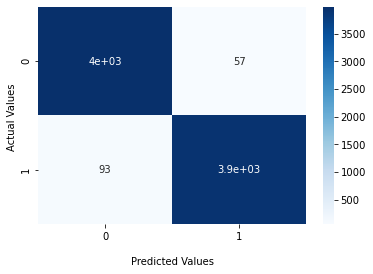

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cfmatrix = confusion_matrix(true_class,class_preds)
ax = sns.heatmap(cfmatrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
## Display the visualization of the Confusion Matrix.
plt.show()